In [1]:
%cd ~/p/npworks/20200222-Vero-SCV2/

/blaze/hyeshik/p/npworks/20200222-Vero-SCV2


In [2]:
from Bio import SeqIO
covseq = str(next(SeqIO.parse(open('refs/SARS-CoV-2.fa'), 'fasta')).seq)

In [3]:
import h5py

In [4]:
sys.path.append('/blaze/hyeshik/nest/tink/gh/poreplex/master')
from poreplex import fast5_file

In [5]:
from glob import glob

In [6]:
from sklearn.linear_model import TheilSenRegressor

In [7]:
kmer_model = \
pd.read_csv('/blaze/hyeshik/nest/tink/gh/poreplex/master/poreplex/kmer_models/r9.4_180mv_70bps_5mer_RNA/template_median69pA.model',
           sep='\t').set_index('kmer', drop=True)
kmer_mean = kmer_model['level_mean'].to_dict()

In [8]:
from scipy.interpolate import CubicSpline
from scipy.signal import medfilt

In [9]:
import random

In [10]:
scaling_ivt = pd.read_csv('stats/IVT1.scaling_params.txt',
                          sep='\t', names=['read_id', 'scale', 'shift']).set_index('read_id')
scaling_vir = pd.read_csv('stats/VeroInf24h.scaling_params.txt',
                          sep='\t', names=['read_id', 'scale', 'shift']).set_index('read_id')
scaling = pd.concat([scaling_ivt, scaling_vir])

In [11]:
ivt_fast5_map = {f.split('/')[-1].split('.')[0]: f for f in glob('subguppy-leader/IVT1-single/*/*.fast5')}

In [12]:
vir_fast5_map = {f.split('/')[-1].split('.')[0]: f for f in glob('subguppy-leader/VeroInf24h-single/*/*.fast5')}

In [13]:
TARGET_SITE = 29015
LEFT_END = TARGET_SITE - 30
RIGHT_END = TARGET_SITE + 31
ORF = 'S'

print('chrSCV\t{}\t{}\tdecoy\t0\t+'.format(LEFT_END, RIGHT_END), file=open('tmp/decoy.bed', 'w'))

!bedtools intersect -abam subset-alignments/VeroInf24h.viral_genome.{ORF}.bam \
 -b tmp/decoy.bed -bed -nonamecheck -split | cut -f4 > tmp/target-candidates

target_read_ids_S = open('tmp/target-candidates').read().split()
random.shuffle(target_read_ids_S)
print('S', len(target_read_ids_S))

ORF = 'N'
!bedtools intersect -abam subset-alignments/VeroInf24h.viral_genome.{ORF}.bam \
 -b tmp/decoy.bed -bed -nonamecheck -split | cut -f4 > tmp/target-candidates

target_read_ids_N = open('tmp/target-candidates').read().split()
random.shuffle(target_read_ids_N)
print('N', len(target_read_ids_N))

S 8644
N 112453


In [14]:
ORF = 'IVT'
!bedtools intersect -abam alignments/IVT1.viral_genome.bam \
 -b tmp/decoy.bed -bed -nonamecheck -split | cut -f4 > tmp/target-candidates

target_read_ids_IVT = open('tmp/target-candidates').read().split()
random.shuffle(target_read_ids_IVT)
print('IVT', len(target_read_ids_IVT))

IVT 219780


In [15]:
N_reads = pd.DataFrame({
    'read_id': pd.Series(target_read_ids_N[:20000])
})
N_reads['sample'] = 'N'
N_reads['filename'] = N_reads['read_id'].apply(lambda x: vir_fast5_map.get(x))
N_reads = pd.merge(N_reads, scaling_vir, left_on='read_id', right_on='read_id').dropna(subset=['filename']).sample(10000)
print(len(N_reads))
N_reads.head()

10000


,read_id,sample,filename,scale,shift
1139,2e0c4240-2d97-41ad-b0c5-05121646a69b,N,subguppy-leader/VeroInf24h-single/20/2e0c4240-...,0.652151,35.589563
3199,9530391b-4afe-4d93-9560-6dc3073ebc2c,N,subguppy-leader/VeroInf24h-single/0/9530391b-4...,0.619136,38.621128
2014,6929106f-2e56-4f98-ac3c-cae9ad7af0c0,N,subguppy-leader/VeroInf24h-single/29/6929106f-...,0.580007,38.525316
6487,2823e1b1-a527-4381-8131-06f081c5d773,N,subguppy-leader/VeroInf24h-single/23/2823e1b1-...,0.699831,33.752582
4563,202686bd-304b-4848-bf61-fb5126739148,N,subguppy-leader/VeroInf24h-single/41/202686bd-...,0.553167,41.379003


In [16]:
S_reads = pd.DataFrame({
    'read_id': pd.Series(target_read_ids_S)
})
S_reads['sample'] = 'S'
S_reads['filename'] = S_reads['read_id'].apply(lambda x: vir_fast5_map.get(x))
S_reads = pd.merge(S_reads, scaling_vir, left_on='read_id', right_on='read_id').dropna(subset=['filename'])#.sample(10000)
print(len(S_reads))
S_reads.head()

5842


,read_id,sample,filename,scale,shift
0,796b0b44-0e2e-4584-b266-d230babf9d06,S,subguppy-leader/VeroInf24h-single/17/796b0b44-...,0.588609,37.214755
1,297b1306-0723-4cac-be09-4741ec782855,S,subguppy-leader/VeroInf24h-single/46/297b1306-...,0.570399,41.943392
2,8de83cd2-0809-421b-805a-2eda369a70d2,S,subguppy-leader/VeroInf24h-single/17/8de83cd2-...,0.578435,37.639134
3,079aa96e-5d64-42b4-95a8-0db9ccf85e4b,S,subguppy-leader/VeroInf24h-single/34/079aa96e-...,0.550629,39.900909
4,9e6b5c8b-d443-43ed-a3b8-3d39cd5295f8,S,subguppy-leader/VeroInf24h-single/31/9e6b5c8b-...,0.606637,39.650707


In [17]:
IVT_reads = pd.DataFrame({
    'read_id': pd.Series(target_read_ids_IVT)
})
IVT_reads['sample'] = 'IVT'
IVT_reads['filename'] = IVT_reads['read_id'].apply(lambda x: ivt_fast5_map.get(x))
IVT_reads = pd.merge(IVT_reads, scaling_ivt, left_on='read_id', right_on='read_id').dropna(subset=['filename']) #.sample(20000, replace=True)
IVT_reads = IVT_reads.drop_duplicates(subset=['read_id'])
print(len(IVT_reads))
IVT_reads.head()

9981


,read_id,sample,filename,scale,shift
0,d27175eb-ad1b-4b39-ad5f-1e27d39f5f71,IVT,subguppy-leader/IVT1-single/18/d27175eb-ad1b-4...,0.580448,38.884283
1,56503d80-862c-4ebd-be58-fa08aab84f3f,IVT,subguppy-leader/IVT1-single/9/56503d80-862c-4e...,0.605717,39.169111
2,f80bcc11-9894-4be7-ace7-43b7614306bd,IVT,subguppy-leader/IVT1-single/22/f80bcc11-9894-4...,0.618208,38.767944
3,1502f018-840d-4326-b734-837dfdb7c43d,IVT,subguppy-leader/IVT1-single/4/1502f018-840d-43...,0.548575,40.880680
4,e465eb36-0a41-4b8a-ac0f-993830f84e1b,IVT,subguppy-leader/IVT1-single/10/e465eb36-0a41-4...,0.600414,34.066239


In [18]:
pd.concat([S_reads, N_reads, IVT_reads]).to_csv('tmp/dwelltime-targets.txt', sep='\t', index=False)

In [19]:
def get_migration_time(filename, start, end, corrected_group):
    read_id = filename.split('/')[-1].split('.')[0]

    with fast5_file.Fast5Reader(filename, read_id) as f5:
        h5 = f5.handle
        try:
            tnode = h5['Analyses/'+corrected_group+'/BaseCalled_template']
        except KeyError:
            return None
        alnattrs = dict(tnode['Alignment'].attrs)
        
        if alnattrs['mapped_start'] > start or alnattrs['mapped_end'] < end:
            return None

        events = pd.DataFrame(tnode['Events'][()])
        events['pos'] = events.index.to_series() + alnattrs['mapped_start']
        events = events[events['pos'].between(start, end)]
        return events['length'].sum()

def load_all_migrations(read_ids, fnmaps, corrected_group):
    rmigtime = []
    for read_id in read_ids:
        if read_id not in fnmaps:
            continue

        ret = get_migration_time(fnmaps[read_id], TARGET_SITE-2, TARGET_SITE+2,
                         corrected_group)
        if ret is not None:
            rmigtime.append(ret)
    return rmigtime

In [20]:
CORRECTED_GROUP_IVT = 'SARSCoV2FullGenomeCorrected_000'
CORRECTED_GROUP_VIRUS = 'RawGenomeCorrected_000'

ivt_migrs = load_all_migrations(list(ivt_fast5_map)[:10000], ivt_fast5_map, CORRECTED_GROUP_IVT)

In [21]:
N_migrs = load_all_migrations(list(target_read_ids_N)[:10000], vir_fast5_map, CORRECTED_GROUP_VIRUS)

In [22]:
S_migrs = load_all_migrations(list(target_read_ids_S)[:10000], vir_fast5_map, CORRECTED_GROUP_VIRUS)

In [23]:
'Done'

'Done'

In [24]:
import sys
sys.path.append('/blaze/hyeshik/nest/tink/p/tailseeker/')
from tailseeker import plotutils

In [25]:
Nx, Ny = plotutils.prepare_cumulative(N_migrs)
Sx, Sy = plotutils.prepare_cumulative(S_migrs)
IVTx, IVTy = plotutils.prepare_cumulative(ivt_migrs)

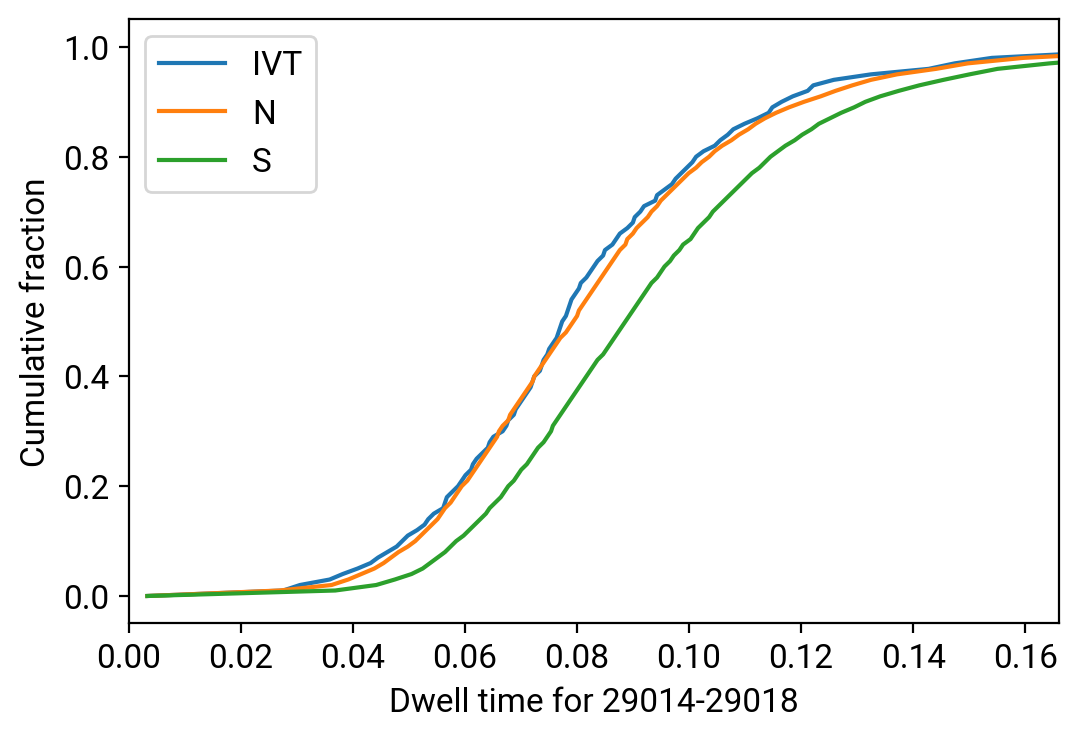

In [26]:
plt.plot(np.array(IVTx) / 3012, IVTy, label='IVT')
plt.plot(np.array(Nx) / 3012, Ny, label='N')
plt.plot(np.array(Sx) / 3012, Sy, label='S')
plt.xlim(0, 500/3012)
plt.xlabel('Dwell time for 29014-29018')
plt.ylabel('Cumulative fraction')
plt.legend()

In [27]:
def load_all_migrations(read_ids, fnmaps, corrected_group, ext=1):
    rmigtime = []
    for read_id in read_ids:
        if read_id not in fnmaps:
            continue

        ret = get_migration_time(fnmaps[read_id], TARGET_SITE-ext, TARGET_SITE+ext,
                         corrected_group)
        if ret is not None:
            rmigtime.append(ret)
    return rmigtime

In [28]:
len(ivt_migrs), len(S_migrs)

(672, 5741)

In [29]:
CORRECTED_GROUP_IVT = 'SARSCoV2FullGenomeCorrected_000'
CORRECTED_GROUP_VIRUS = 'RawGenomeCorrected_000'

ivt_migrs_e1 = load_all_migrations(list(ivt_fast5_map)[:90000], ivt_fast5_map, CORRECTED_GROUP_IVT)
N_migrs_e1 = load_all_migrations(list(target_read_ids_N)[:10000], vir_fast5_map, CORRECTED_GROUP_VIRUS)
S_migrs_e1 = load_all_migrations(list(target_read_ids_S)[:10000], vir_fast5_map, CORRECTED_GROUP_VIRUS)

In [30]:
'Done'

'Done'

In [31]:
dwellwide = \
pd.read_csv('basemod/dwell/dwell-result.txt',
           sep='\t', names=['pos', 'length', 'sample', 'read_id'])

In [32]:
sys.path.append('/blaze/hyeshik/nest/tink/p/tailseeker')
from tailseeker import plotutils

In [33]:
SURVEY_RANGE_1 = (29015, 29017) # 1-based, inclusive
SURVEY_RANGE_CTL = (29010, 29012)

inrange1 = dwellwide[dwellwide['pos'].between(SURVEY_RANGE_1[0] - 1, SURVEY_RANGE_1[1] - 1)]
inrange1.head()

,pos,length,sample,read_id
29,29014,30,S,920a3e93-99fe-4b06-8274-ca81cd45e661
30,29015,27,S,920a3e93-99fe-4b06-8274-ca81cd45e661
31,29016,96,S,920a3e93-99fe-4b06-8274-ca81cd45e661
91,29014,50,S,b678de9f-fd6e-40af-be6b-153decc0dacf
92,29015,7,S,b678de9f-fd6e-40af-be6b-153decc0dacf


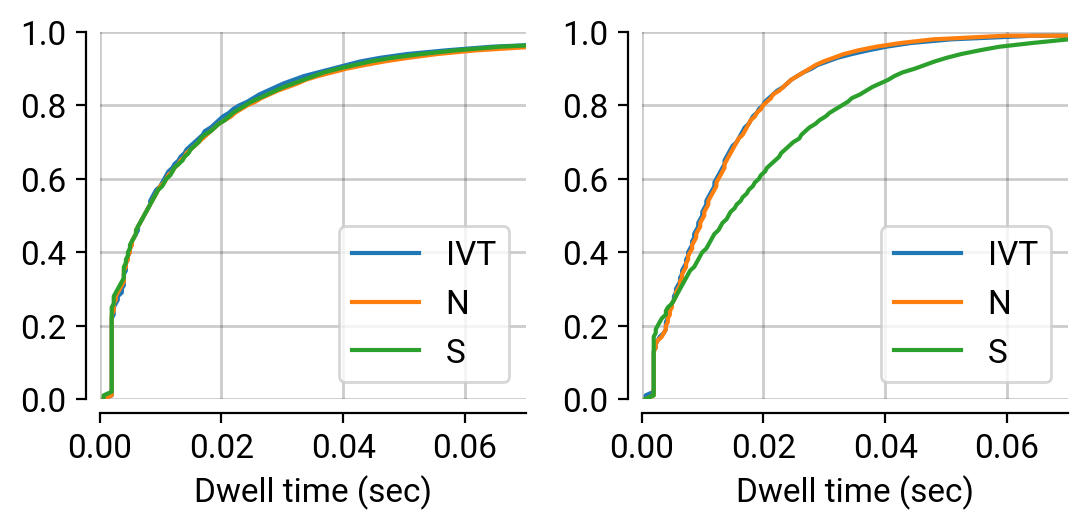

In [34]:
def plot_sigdwells(ax, rangestart, rangeend):
    inrange1 = dwellwide[dwellwide['pos'].between(rangestart - 1, rangeend - 1)]

    for grpname, rows in inrange1.groupby('sample'):
        cumx, cumy = plotutils.prepare_cumulative(rows['length'] / 3012)
        ax.plot(cumx, cumy, label=grpname)
    ax.set_xlim(0, 0.07)
    ax.legend()

fig, axes = plt.subplots(1, 2, figsize=(5.6, 2.8))

plot_sigdwells(axes[1], 29015, 29017)
plot_sigdwells(axes[0], 28995, 28997)

def tune_axis(ax):
    ax.set_xlabel('Dwell time (sec)')
    for spname in 'top right'.split():
        ax.spines[spname].set_visible(False)

    #plt.setp(ax.get_yticklines(), visible=False)
    #plt.setp(ax.get_yticklabels(), visible=False)
    ax.spines['bottom'].set_position(('outward', 5))
    ax.spines['left'].set_position(('outward', 5))
    ax.grid(True, color='black', alpha=.2, lw=1)
    ax.set_ylim(0, 1)


tune_axis(axes[0])
tune_axis(axes[1])

plt.tight_layout()
plt.savefig('figure-outputs/plot-dwell.pdf')